In [1]:
from wKit.vis import plotly_fig

In [11]:
from read_db_json import *
from importlib import reload

import os

In [3]:
from sklearn.metrics import r2_score, mean_squared_error

In [4]:
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

In [5]:
# date = '2017-09-29'
date='2017-08-30'
date = '2017-10-01'

In [6]:
# ratings = large_joint_table(date=date)
joint_table = load_joint_table2(date=date)

with test (1476, 13)
without test users (1476, 13)


In [7]:
joint_table.shape

(2339, 32)

In [8]:
y_all = weighted_seg_score(joint_table)

y_all.shape

(442, 1)

In [7]:
# y_all.to_csv('ys/{0}/y_csl_all-{0}.csv'.format(date))

# EXP1 3 levels

In [40]:
y_all_3 = (y_all-1)/(5-1) * (3-1) + 1

In [41]:
y_all_3.to_csv('ys/{0}/y_csl_all_3level-{0}.csv'.format(date))

In [69]:
y_all_4 = (y_all-1)/(5-1) * (4-1) + 1

In [8]:
y_all_4.to_csv('ys/{0}/y_csl_all_4level-{0}.csv'.format(date))

In [71]:
%matplotlib inline

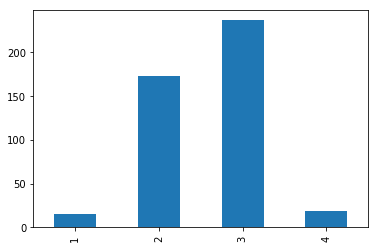

In [80]:
y_all_4.csl.round().value_counts().loc[[1,2,3,4]].plot(kind='bar')

# EXP1 weighted score by familiar or explvl

In [12]:
import diff_weight; reload(diff_weight)
from diff_weight import *

In [26]:
mapping = {  'lvl_fearless_1st': 'fearless=4', 'lvl_reluctant_1st': 'reluctant=4', 'fam_include_noinfo': 'familarity=3',
             'fam_exclude_noinfo': 'familarity=2',
             'ext_lvl_fearless_1st': 'fearless=100',
             'ext_lvl_reluctant_1st': 'reluctant=100',
             'ext_fam_include_noinfo': 'familarity=100,unknown=50',
             'ext_fam_exclude_noinfo': 'familarity=100,unknown=0',
             'f4_c1_i1_r4': 'f=r=4,c=i=1',
             'f10_c1_i1_r10': 'f=r=10,c=i=1',
             'not_familiar_include_no_info': 'nf=30,f=unk=1',
             'nf30_f10_unk1': 'nf30_f10_unk1',
             'f10_c1_i1_r10': 'f10_c1_i1_r10',
           'nf30_f1_unk1': 'nf30_f1_unk1',
           '': 'no ratio'

}

In [22]:
joint_table['lvl_fearless_1st'] = joint_table.experienceLevel.apply(lvl_fearless_1st)
joint_table['lvl_reluctant_1st'] = joint_table.experienceLevel.apply(lvl_reluctant_1st)
joint_table['fam_include_noinfo'] = joint_table.familiar.apply(familiar_include_no_info)
joint_table['fam_exclude_noinfo'] = joint_table.familiar.apply(familiar_exclude_no_info)
joint_table['ext_lvl_fearless_1st'] = joint_table.experienceLevel.apply(ext_lvl_fearless_1st)
joint_table['ext_lvl_reluctant_1st'] = joint_table.experienceLevel.apply(ext_lvl_reluctant_1st)
joint_table['ext_fam_include_noinfo'] = joint_table.familiar.apply(ext_familiar_include_no_info)
joint_table['ext_fam_exclude_noinfo'] = joint_table.familiar.apply(ext_familiar_exclude_no_info)


joint_table['f4_c1_i1_r4'] = joint_table.experienceLevel.apply(f4_c1_i1_r4)
joint_table['f10_c1_i1_r10'] = joint_table.experienceLevel.apply(f10_c1_i1_r10)
joint_table['nf30_f1_unk1'] = joint_table.familiar.apply(nf30_f1_unk1)
joint_table['nf30_f10_unk1'] = joint_table.familiar.apply(nf30_f10_unk1)

In [32]:
def weighted_seg_score_by_add_weight(df, weighted_col, col_name='csl'):
    if df.shape[0]==0:
        return pd.DataFrame()
    
    score = df[df[weighted_col]!=0].groupby('index_seg').apply(lambda x: 
                                          (x.score * x.ratio * x[weighted_col]).sum() / (x.ratio*x[weighted_col]).sum()
                                         ).to_frame()


    score.columns = [col_name]
    return score


In [40]:
weighted_ys = []
weighted_ys_name = []
for weighted_col in ['lvl_fearless_1st', 'ext_lvl_fearless_1st', 'lvl_reluctant_1st', 'ext_lvl_reluctant_1st', 
                     'fam_include_noinfo', 'ext_fam_include_noinfo', 'fam_exclude_noinfo', 'ext_fam_exclude_noinfo',
#                     'f4_c1_i1_r4',
                     'f10_c1_i1_r10', 
                     'nf30_f1_unk1',
#                      'nf30_f10_unk1',
                    ]:
    weighted_y = weighted_seg_score_by_add_weight(joint_table, weighted_col)
    weighted_ys.append(weighted_y.csl.values)
    weighted_ys_name.append(weighted_col)
    fn = 'ys/{0}/y_csl_all_{1}-{0}.csv'.format(date, weighted_col)
    if os.path.exists(fn):
        continue
    weighted_y.to_csv(fn)
new_ys_name = [mapping[name] for name in weighted_ys_name]

In [35]:
arrs = [y_all.csl.values]+weighted_ys
title = 'score histogram of % segments of different weight schema'
arrs = [y_all.csl.round().values] + [y.round() for y in weighted_ys]
title = '% segments per level of different weight schema'

fig = plotly_fig.hist(arrs, names=['default weight']+new_ys_name, title=title)
iplot(fig)

### no ratio

In [19]:
def weighted_seg_no_ratio(df, weighted_col='', col_name='csl'):
    if df.shape[0]==0:
        return pd.DataFrame()
    
    if weighted_col=='':
        score = df.groupby('index_seg').apply(lambda x: x.score.mean()).to_frame()
    else:
        score = df[df[weighted_col]!=0].groupby('index_seg').apply(lambda x: 
                                          (x.score * x[weighted_col]).sum() / (x[weighted_col]).sum()
                                         ).to_frame()


    score.columns = [col_name]
    return score    

In [28]:
weighted_ys = []
weighted_ys_name = []
for weighted_col in ['',
                     'lvl_fearless_1st', 
#                      'ext_lvl_fearless_1st', 
                     'lvl_reluctant_1st', 
#                      'ext_lvl_reluctant_1st', 
                     'fam_include_noinfo', 
#                      'ext_fam_include_noinfo', 
                     'fam_exclude_noinfo', 
#                      'ext_fam_exclude_noinfo',
#                      'f10_c1_i1_r10', 
#                      'nf30_f1_unk1',
                    ]:
    weighted_y = weighted_seg_no_ratio(joint_table, weighted_col)
    weighted_ys.append(weighted_y.csl.values)
    weighted_ys_name.append(weighted_col)
    fn = 'ys/{0}/y_csl_all_noratio_{1}-{0}.csv'.format(date, weighted_col)
    if os.path.exists(fn):
        print(fn, 'exists')
        continue
    weighted_y.to_csv(fn)
new_ys_name = [mapping[name] for name in weighted_ys_name]

ys/2017-10-01/y_csl_all_noratio_-2017-10-01.csv exists
ys/2017-10-01/y_csl_all_noratio_lvl_fearless_1st-2017-10-01.csv exists
ys/2017-10-01/y_csl_all_noratio_lvl_reluctant_1st-2017-10-01.csv exists
ys/2017-10-01/y_csl_all_noratio_fam_include_noinfo-2017-10-01.csv exists
ys/2017-10-01/y_csl_all_noratio_fam_exclude_noinfo-2017-10-01.csv exists
ys/2017-10-01/y_csl_all_noratio_f10_c1_i1_r10-2017-10-01.csv exists


In [29]:
arrs = [y_all.csl.values]+weighted_ys
title = 'score histogram of % segments of different weight schema'
arrs = [y_all.csl.round().values] + [y.round() for y in weighted_ys]
title = '% segments per level of different weight schema'

fig = plotly_fig.hist(arrs, names=['default weight']+new_ys_name, title=title)
iplot(fig)

### amplify score

In [13]:
reload(diff_weight); from diff_weight import *

In [14]:
joint_table['amplify_fcir'] = joint_table.apply(amplify_fcir, axis=1)
joint_table['amplify_fr'] = joint_table.apply(amplify_fr, axis=1)

In [15]:
amplify_ys = []
amplify_names = []
for amp in [
    'amplify_fcir', 'amplify_fr'
]:
    ey = weighted_seg_score(joint_table, score_col=amp)
    ey[ey<1] =1
    ey[ey>5]=5
    amplify_ys.append(ey.csl)
    amplify_names.append(amp)
    
    fn = 'ys/{0}/y_csl_all_{1}-{0}.csv'.format(date, amp)
    if os.path.exists(fn):
        print(fn,'exist')
        continue
    ey.to_csv(fn)

In [16]:
arrs = [y_all.csl.values]+amplify_ys
title = 'score histogram of % segments of different weight schema'
arrs = [y_all.csl.round().values] + [y.round() for y in amplify_ys]
title = '% segments per level of different weight schema'

fig = plotly_fig.hist(arrs, names=['default weight']+amplify_names, title=title)
iplot(fig)

In [39]:
y_all.round().csl.value_counts()

3.0    203
4.0    158
2.0     62
1.0     12
5.0      7
Name: csl, dtype: int64

# EXP4 find sub type worth experimenting

In [22]:
def get_stat(filtered_ratings, col, label):
    if filtered_ratings.shape[0]==0:
        return {'question': col, 'answer':label, '#data points': 0}
    else:
        cmp_all = y_all.join(filtered_ratings, lsuffix='_all', how='inner')    
        r2 = r2_score(cmp_all.csl_all, cmp_all.csl)
        rmse = pd.np.sqrt(mean_squared_error(cmp_all.csl_all, cmp_all.csl))
        same_class_pcnt = (cmp_all.csl_all.round()==cmp_all.csl.round()).mean()
        return {
            'question': col, 'answer': label, '#data points':filtered_ratings.shape[0],
            'r2' : r2, 'rmse': rmse, 'same_class_percentage': same_class_pcnt,
        }

In [24]:
y_shape_with_filtered = []
for col, labels in SURVEY_DICT.items():
    question_col = joint_table[col].fillna(0).astype(int)
    for i, label in enumerate(labels):  
        filtered_ratings = weighted_seg_score(joint_table[question_col==i])
        stat = get_stat(filtered_ratings, col, label)
        y_shape_with_filtered.append(stat)

col = 'experienceLevel'
question_col = joint_table[col].fillna('No Info')
for label in ['No Info', 'fearless', 'confident', 'interested', 'reluctant']:
    filtered_ratings = weighted_seg_score(joint_table[question_col==label])
    stat = get_stat(filtered_ratings, col, label)
    y_shape_with_filtered.append(stat)
    

In [25]:
df_y_shape=pd.DataFrame(y_shape_with_filtered)

### compare diff weight formula

In [27]:
df_y_shape[['question', 'answer', '#data points', 'r2', 'rmse', 'same_class_percentage']].to_csv(
    'ys/{0}/filtered_y_shape.csv'.format(date), encoding='utf8')

In [14]:
def weighted_seg_score_by_add_weight2(df, weighted_col, col_name='csl'):
    if df.shape[0]==0:
        return pd.DataFrame()
    
    score = df[df[weighted_col]!=0].groupby('index_seg').apply(lambda x: 
                                          (x.score * x.ratio * x[weighted_col]).sum() / (x.ratio.sum() *x[weighted_col].sum())
                                         ).to_frame()


    score.columns = [col_name]
    return score


In [18]:
weighted_y = weighted_seg_score_by_add_weight(joint_table, 'fam_include_noinfo')
weighted_y2 = weighted_seg_score_by_add_weight2(joint_table, 'fam_include_noinfo')
weighted_y.columns = ['optionA']
weighted_y2.columns = ['optionB']
# y_all.join(weighted_y).join(weighted_y2)

# EXP4 get sub ys

In [45]:
sub_ys = {}

for col, labels in SURVEY_DICT.items():
    # consider these 4 types+exp lvl only
    if col not in ['bk_purpose', 'household_income', 'age', 'bk_type', 'gender']:
        continue
    question_col = joint_table[col].fillna(0).astype(int)
    for i, label in enumerate(labels):  
        # exclude no Info
        if i==0:
            continue
        filtered_ratings = weighted_seg_score(joint_table[question_col==i])
        if filtered_ratings.shape[0]>100:
            sub_ys[(col, label)] = filtered_ratings

col = 'experienceLevel'
question_col = joint_table[col].fillna('No Info')
for label in ['No Info', 'fearless', 'confident', 'interested', 'reluctant']:
    filtered_ratings = weighted_seg_score(joint_table[question_col==label])
    if filtered_ratings.shape[0]>100:
        sub_ys[(col, label)] = filtered_ratings

In [46]:
sub_ys.keys()

dict_keys([('bk_purpose', 'Mainly utility biking – traveling from one location to another'), ('bk_purpose', 'Mainly recreational biking – biking for recreation, leisure, and health'), ('bk_purpose', '50% utility, 50% recreational'), ('age', '25-34'), ('age', '35-44'), ('age', '45-54'), ('age', '55-64'), ('age', '65-74'), ('gender', 'Female'), ('gender', 'Male'), ('household_income', 'Less than $24,999'), ('household_income', '$55,000 to $69,999'), ('household_income', '$70,000 to $84,999'), ('household_income', '$85,000 to $99,999'), ('household_income', '$100,000 to $149,999'), ('household_income', '$150,000 or more'), ('bk_type', 'CaBi Bike (Shared bike in the DC region)'), ('bk_type', 'Road Bike'), ('bk_type', 'Hybrid Bike'), ('experienceLevel', 'fearless'), ('experienceLevel', 'confident'), ('experienceLevel', 'interested')])

In [45]:
for key, df in sub_ys.items():
    q, a = key[0], key[1].split('–')[0]
    fn = 'ys/{0}/exp4_ys/y_csl_{1}#{2}-{0}.csv'.format(date, q, a)
    df.to_csv(fn, encoding='utf8')

In [64]:
from collections import defaultdict
qs = set()
all_names = defaultdict(list)
all_ys = defaultdict(list)

for key, df in sub_ys.items():
    q, a = key[0], key[1].split('–')[0]
    qs.add(q)
    all_names[q].append('%s=%s' %(q, a.replace('$', '')))
    all_ys[q].append(df.csl.values)

In [67]:
for q in list(qs):
    ys = all_ys[q]
    names = all_names[q]
    arrs = [y_all.csl.values]+ys
    title = 'score histogram of % segments by '+q
    arrs = [y_all.csl.round().values] + [y.round() for y in ys]
    title = '% segments per level by '+q

    fig = plotly_fig.hist(arrs, names=['default weight']+names, title=title)
    iplot(fig)

# EXP5 reconstruction

In [10]:
SAMPLING_SEEDS = [6412, 9978, 5876, 5319, 5512, 4737, 4934, 2097, 1151, 5237,
                  52418, 72004, 78206, 24561, 74607, 72427,  3629, 48849,  9885,  4227,
                  99079, 90335]

In [19]:
import math

In [26]:
import numpy as np
np.random.randint(100000, size=10)

array([99079, 90335, 98797, 81825, 42424, 56650, 90140, 47699, 49569, 78576])

In [14]:
import os

In [30]:
for frac in range(90, 0, -10):
    n_repeat = math.ceil(math.log(0.1, 1-frac/100))
    print('====frac:', frac, n_repeat)
    
    for sample_seed in SAMPLING_SEEDS[:n_repeat]:
        fn = 'ys/%s/exp5_reconstruction/y_csl_frac_sample#%d#%d.csv'% (date, frac, sample_seed)
        if os.path.exists(fn):
            print(fn, 'exists')
            continue
        sampled_joint_table = joint_table.sample(frac=frac/100.0, random_state=sample_seed)
        sampled_y = weighted_seg_score(sampled_joint_table)
        print(sample_seed, sampled_joint_table.shape, sampled_y.shape, sampled_y.csl.round().value_counts().to_dict())
        sampled_y.to_csv(fn)

====frac: 90 1
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#90#6412.csv exists
====frac: 80 2
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#80#6412.csv exists
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#80#9978.csv exists
====frac: 70 2
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#70#6412.csv exists
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#70#9978.csv exists
====frac: 60 3
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#60#6412.csv exists
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#60#9978.csv exists
5876 (1403, 32) (412, 1) {3.0: 184, 4.0: 133, 2.0: 71, 1.0: 12, 5.0: 12}
====frac: 50 4
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#50#6412.csv exists
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#50#9978.csv exists
5876 (1170, 32) (390, 1) {3.0: 174, 4.0: 127, 2.0: 69, 1.0: 11, 5.0: 9}
5319 (1170, 32) (393, 1) {3.0: 169, 4.0: 137, 2.0: 67, 5.0: 12, 1.0: 8}
====frac: 40 5
ys/2017-10-01/exp5_reconstruction/y_csl_frac_sample#40